# **1. Legendre Features using OLS**

## **1.1 First experiment $(2x + cos(25x))$**

We are going to approximate an objective function using Legendre polynomial regression, following "arXiv:2303.14151" and using OLS (Ordinary Least Squares).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Objective function

First, we define the function we want to approximate. In our case, we will work with the following function:

$$
  y(x) = 2x + cos(25x)
$$

In [ ]:
def objective_function1(x):
  '''
  Objective function (unknown) we want to approximate using training data. In this
  case we use y(x) = 2x + cos(25x) as objective function.

  '''
  # We use y(x) = 2x + cos(25x) as objective function, following "arXiv:2303.14151"
  return np.float64(2*x+ np.cos(25*x))

Next, let's plot the function we want to approximate in the interval $[-1, 1]$. To do this, we define a series of equispaced points in that interval to which we apply the function (these points will be our test data).

In [ ]:
def plot_objective_function(objective_function, function, lower_bound=-1.0, higher_bound=1.0, num_points=1000):
  '''
  Function to plot the given objective function over the interval [lower_bound, higher_bound].

  '''
  # Following "arXiv:2303.14151" we wish to predict objective function from x ∈ [-1, 1]
  # In order to plot the objective function we create 1000 points equispaced on the interval and we apply the objective function to them
  X_test = np.linspace(lower_bound, higher_bound, num=num_points)
  y_test = objective_function(X_test)

  # We need to normalize x to the range [-1, 1] in order to use Legendre polynomials
  X_test = 2 * (X_test - lower_bound) / (higher_bound - lower_bound) - 1

  # Now we plot the objective function in the interval [-1, 1]
  sns.lineplot(x=X_test, y=y_test, label="Objective function")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.title(f"Function to approximate: {function}", fontweight='bold')
  plt.legend()
  plt.show()

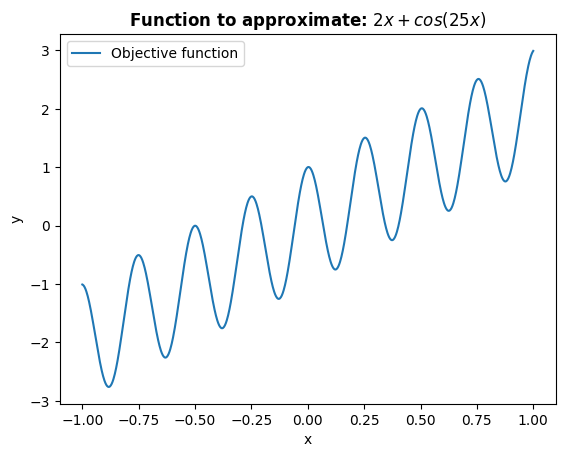

In [ ]:
plot_objective_function(objective_function1, "$2x + cos(25x)$")

To create our training set, we define the functions **"generate_training_data()"** and **"generate_uniformly_distributed_training_data()"** to obtain a predetermined number of training points.

In [ ]:
def generate_training_data(low, high, num_samples, objective_function):
  '''
  The function is given two limits: low and high and a desired number of samples
  to create samples that are uniformly distributed over the interval [low, high)
  and to which the objective function is applied.

  Example of use:
  X_train, y_train = generate_training_data(-1, 1, 10, x**2)

  '''
  # We use "np.random.uniform" to create samples that are uniformly distributed over the interval [low, high)
  X = np.random.uniform(low=low, high=high, size=num_samples)
  # We apply the objective function to the samples
  y = objective_function(X)
  return X, y

In [ ]:
def generate_uniformly_distributed_training_data(low, high, num_samples, objective_function, num_intervals = 5):
  '''
  Generates uniformly distributed data over a number of intervals within the range [low, high).

  The function divides the interval [low, high) into a fixed number of sub-intervals and
  generates uniformly distributed samples within each sub-interval. Then, it applies
  the objective function to the generated samples.

  Example of use:
  X_train, y_train = generate_uniformly_distributed_training_data(-1, 1, 10, x**2)

  '''
  samples_per_interval = num_samples // num_intervals

  X = []
  for i in range(num_intervals):
      sub_low = low + i * (high - low) / num_intervals
      sub_high = low + (i + 1) * (high - low) / num_intervals
      X.extend(np.random.uniform(low=sub_low, high=sub_high, size=samples_per_interval))

  X = np.array(X)
  # Normalize X in the interval [-1, 1] (for Legendre approximation)
  X_normalized = 2 * (X - low) / (high - low) - 1
  y = objective_function(X)
  return X_normalized, y

In addition, we define a function **"plot_objective_function_and_training_data()"** to plot both the training points and the objective function.

In [ ]:
def plot_objective_function_and_training_data(X_train, y_train, X_test, y_test):
  '''
  Function to plot the training data (X_train, y_train) together with the
  objective function (X_test, y_test).

  '''
  # To make sure we are working with 1D arrays
  X_train = X_train.reshape(-1)
  X_test = X_test.reshape(-1)

  # We plot the figure containing the objective function and the training data
  plt.figure()
  # Objective function
  sns.lineplot(x=X_test, y=y_test, label="Objective function")
  # Training data
  sns.scatterplot(x=X_train, y=y_train, s=50, color="black", label="Training data")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.legend(loc="upper left")
  plt.show()

### Training data

We start by generating our training data (10 samples) and plotting it together with the objective function.

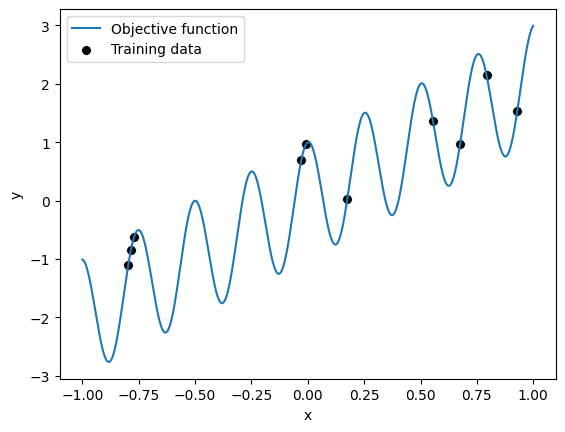

In [ ]:
# Here we generate the training data and we plot them together with the objective function
lower_bound, higher_bound = -1.0, 1.0
X_test = np.linspace(lower_bound, higher_bound, num=1000)
y_test = objective_function1(X_test)
n_samples = 10
X_train, y_train = generate_training_data(lower_bound, higher_bound, n_samples, objective_function1)
plot_objective_function_and_training_data(X_train, y_train, X_test, y_test)

### Legendre approximation

We define the function **"fit_legendre_polynomial_regression()"** to fit the Legendre polynomials to the samples we have.

In [ ]:
from scipy.special import eval_legendre

def fit_legendre_polynomial_regression(degree, X_train, y_train, X_test):
  '''
  Function to perform the polynomial approximation (using Legendre polynomials).
  We need the desired degree for the approximation, the training data and the test data.

  Recall that the Legendre approximation is based on the following polynomial:
  f(x) ≈ a_0*P_0(x) + a_1*P_1(x) + ... + a_n*P_n(x) where P_i(x) is the i-th Legendre polynomial (https://mathworld.wolfram.com/LegendrePolynomial.html).

  Example of use:
  X_train_poly, y_train_pred, y_test_pred = fit_legendre_polynomial_regression(1, X_train, y_train, X_test)

  '''
  # In order to approximate the i-th Legendre polynomial, we need all the P_j(x) {j ∈ [1, n]} Legendre polynomials, so we create an array with all these necessary indices
  # "np.arange" is returning an array consisting of [0, degree-1] so we need to sum "1" in every index
  degrees = np.arange(degree) + 1

  # We need to work with 2D arrays to use "eval_legendre" function
  X_train = X_train.reshape(-1, 1)
  X_test = X_test.reshape(-1, 1)

  # We use "eval_legendre" function to evaluate the d-th Legendre polynomial at each training point in X_train (we need all the P_j(x) {j ∈ [1, n]} Legendre polynomials to approximate)
  X_train_poly = np.column_stack([eval_legendre(d, X_train) for d in degrees])
  # We use "eval_legendre" function to evaluate the d-th Legendre polynomial at each test point in X_test
  X_test_poly = np.column_stack([eval_legendre(d, X_test) for d in degrees])

  # In order to calculate w (vector of weights/coefficients for the regression) we need (check slide 15/23 from https://work.caltech.edu/slides/slides03.pdf):
    # 1. We need to compute the pseudo-inverse of X_train_poly (which contains the Legendre features of the polynomial regression)
    # 2. We need to multiply the pseudo-inverse by the y_train data
  w = np.matmul(np.linalg.pinv(X_train_poly), y_train)

  # Here we calculate the predictions of the training and test data with the vector w of weights
  y_train_pred = np.matmul(X_train_poly, w)
  y_test_pred = np.matmul(X_test_poly, w)

  return X_train_poly, y_train_pred, y_test_pred

We also define a function to plot the approximation made by the Legendre polynomials.

In [ ]:
def plot_fitting_approximation(X_train, y_train, X_test, y_test, y_test_pred, degree, y_lower, y_upper):
  '''
  Function to plot the training data (X_train, y_train) together with the
  objective function (X_test, y_test) and the fitted function (y_test_pred) for
  the specified number of params (degree) along the y-axis [y_lower, y_upper].

  '''
  # To make sure we are working with 1D arrays
  X_train = X_train.reshape(-1)
  X_test = X_test.reshape(-1)

  # We plot the figure containing the objective function, the training data and the fitted function
  plt.figure()
  sns.lineplot(x=X_test, y=y_test, label="Objective function")
  sns.lineplot(x=X_test, y=y_test_pred, label=f"Fitted function - {degree} params")
  sns.scatterplot(x=X_train, y=y_train, s=50, color="black", label="Training data")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.ylim(y_lower, y_upper)
  plt.legend(loc="upper left")
  plt.show()

### Training the model

Now, we will approximate the training data using Legendre's polynomial approximation for different degrees of freedom (degrees of the polynomial to be fitted) and calculate both training and test loss.

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Number of params we want to use for the approximation (we use [1, 200] params following "arXiv:2303.14151")
degrees = list(range(1, 201))

# For each degree in [1, 200] we calculate the fitted function and see how it fits the objective function by using MSE in training and test.
for degree in degrees:
  X_train_poly, y_train_pred, y_test_pred = fit_legendre_polynomial_regression(degree, X_train, y_train, X_test)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "X_train_poly": X_train_poly, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# We convert the output into a pandas dataframe
output_df = pd.DataFrame(output)

# of parameters = 1, train_loss = 0.2546, test_loss = 0.4990
# of parameters = 2, train_loss = 0.2546, test_loss = 0.4990
# of parameters = 3, train_loss = 0.2356, test_loss = 0.5270
# of parameters = 4, train_loss = 0.2303, test_loss = 0.5173
# of parameters = 5, train_loss = 0.1841, test_loss = 0.7673
# of parameters = 6, train_loss = 0.0915, test_loss = 0.8475
# of parameters = 7, train_loss = 0.0757, test_loss = 1.0521
# of parameters = 8, train_loss = 0.0693, test_loss = 1.2024
# of parameters = 9, train_loss = 0.0048, test_loss = 10.5021
# of parameters = 10, train_loss = 0.0000, test_loss = 4.0892
# of parameters = 11, train_loss = 0.0000, test_loss = 3.9164
# of parameters = 12, train_loss = 0.0000, test_loss = 3.8855
# of parameters = 13, train_loss = 0.0000, test_loss = 3.5689
# of parameters = 14, train_loss = 0.0000, test_loss = 3.0333
# of parameters = 15, train_loss = 0.0000, test_loss = 1.9970
# of parameters = 16, train_loss = 0.0000, test_loss = 1.4689
# of parameters 

We can check the approximations made for each degree of the Legendre polynomial.

In [ ]:
degree = 1
print("Training data values: ", X_train)
print()
# We know that P_1(x) = x, so the values for X_train_poly using degree = 1 must be the same values as X_train
print("X_train_poly values: ", output_df.loc[degree-1, 'X_train_poly'].reshape(-1))

Training data values:  [-0.78929869 -0.94228507 -0.58345553 -0.03981376 -0.32667777  0.66679272
  0.3126241   0.81955621  0.78291738  0.27533444]

X_train_poly values:  [-0.78929869 -0.94228507 -0.58345553 -0.03981376 -0.32667777  0.66679272
  0.3126241   0.81955621  0.78291738  0.27533444]


### Some approximations

We now plot some of the approximations obtained by the Legendre polynomials (we note that the higher the degree used for the approximation the smoother the fitted function).

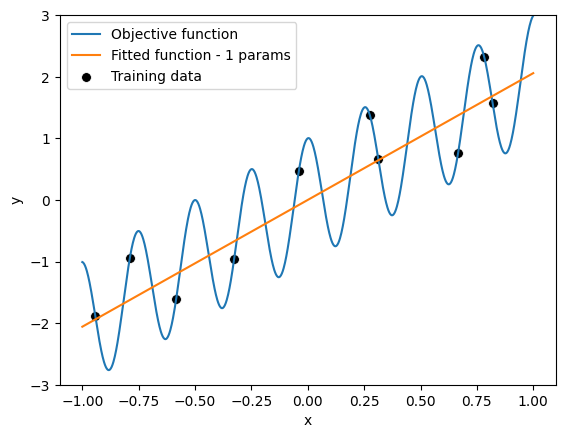

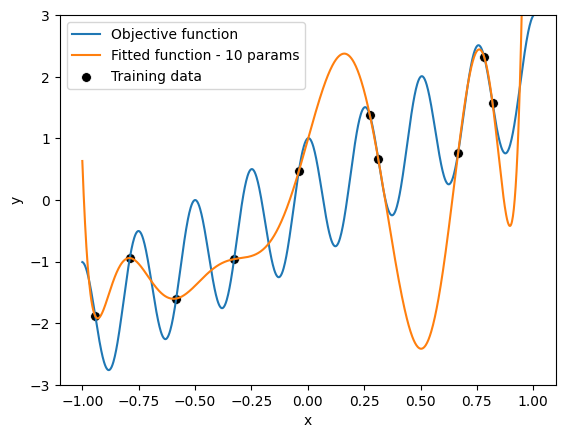

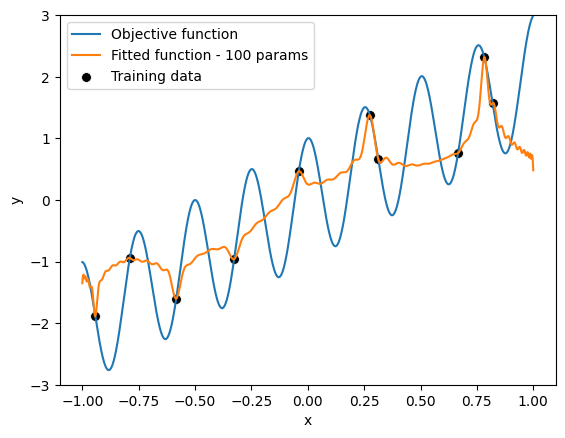

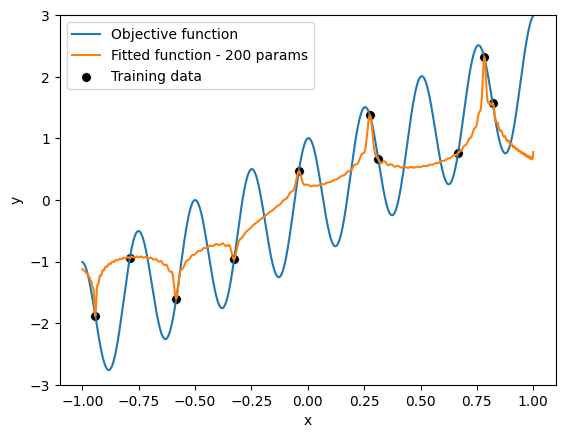

In [ ]:
# We plot the objective function, fitted function and training data
y_lower, y_upper = -3, 3
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

### Double descent phenomenon

Finally, we plot both the training error curve and the test error curve. We observe how the double descent phenomenon occurs and where the peak of the test error is close to the interpolation threshold (≈ number of training samples when there is no label noise).

In [ ]:
def plot_double_descent(output_df, samples, function, legendre = True, ylim_bottom = 0.001):
  '''
  Function to plot the double descent phenomenon, using the MSE error metric
  (We use the output dataframe to recover all information we need to plot). If
  legendre = True then legendre approximation is performed.

  '''
  plt.figure(figsize=(12, 8))
  # Test loss / Test error
  sns.lineplot(
      data=output_df,
      x="# of parameters",
      y="test_error",
      label="Test",
      marker="D",
  )
  # Train loss / Train error
  sns.lineplot(
      data=output_df,
      x="# of parameters",
      y="train_error",
      label="Train",
      marker="D",
  )
  plt.ylabel("Mean Squared Error (MSE)")
  plt.xlabel("# of Parameters")

  if ylim_bottom > 0:
    plt.ylim(ylim_bottom)

  plt.xscale("log")
  plt.yscale("log")
  title_prefix = "Legendre" if legendre else ""
  plt.title(f"{title_prefix} Polynomial Regression (Train/Test Error by number of parameters (degrees)) for {function}", fontweight='bold')
  # Interpolation threshold ≈ number of training data samples used
  plt.axvline(x=samples, color="black", linestyle="--", label="Interpolation threshold")
  plt.legend(loc="upper right")

  plt.tight_layout()
  plt.show()

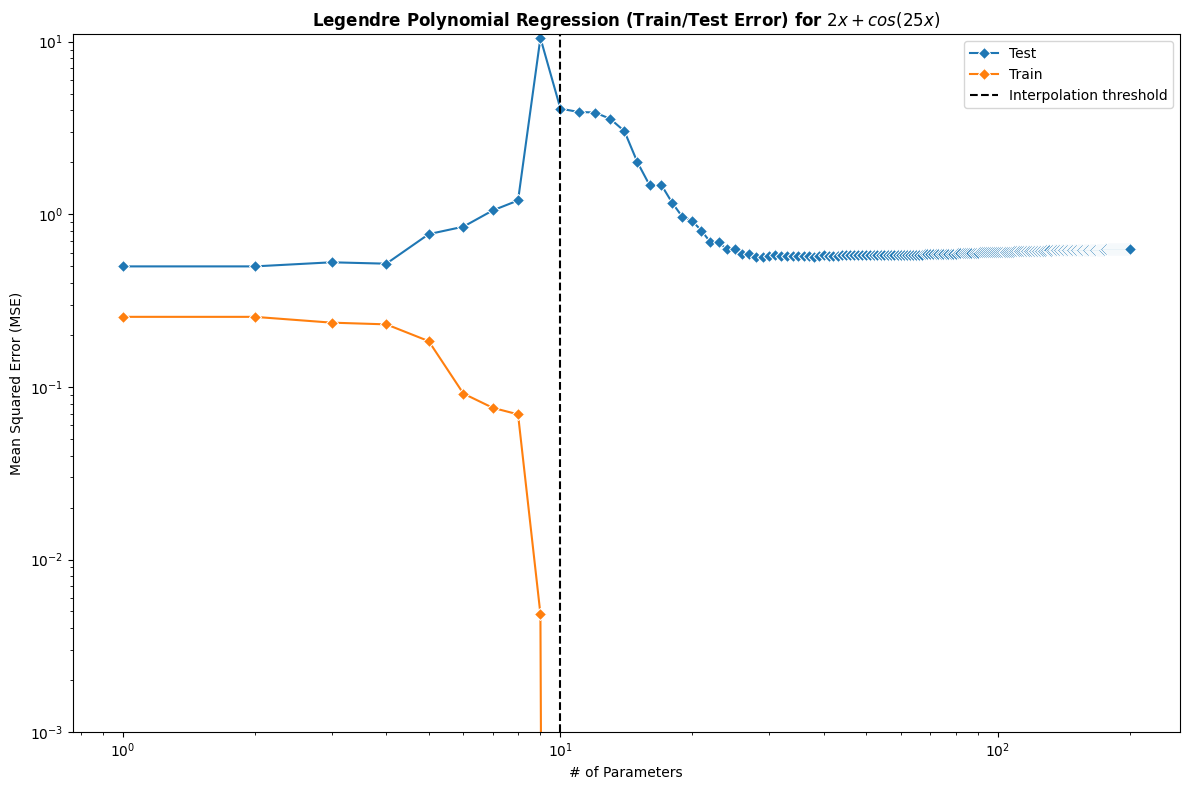

In [ ]:
plot_double_descent(output_df, n_samples, "$2x + cos(25x)$")

\

## **1.2 Second experiment $(x^2 + cos(25x))$**

We are now going to change our objective function to observe the behavior of double descent on different types of functions. To do this, we will change the function that governs the trend of the objective function ($2x$) and keep the function that injects “noise” into the objective function ($cos(25x)$).

In [ ]:
def objective_function2(x):
  '''
  Objective function (unknown) we want to approximate using training data. In this
  case we use y(x) = x**2 + cos(25x) as objective function

  '''
  return np.float64(x**2 + np.cos(25*x))

The new objective function changes the trend function ($2x$) from linear to quadratic ($x^2$).

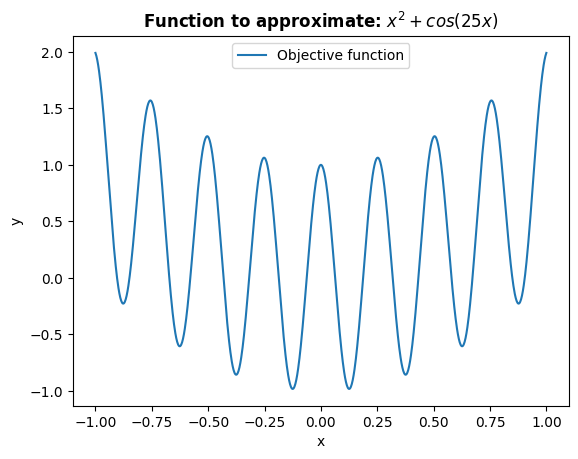

In [ ]:
plot_objective_function(objective_function2, "$x^2 + cos(25x)$")

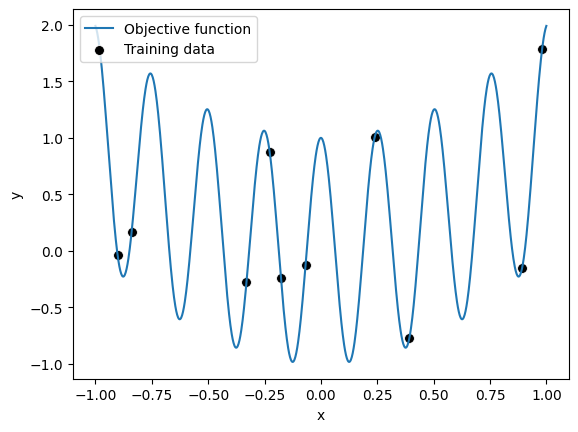

In [ ]:
# Here we generate the training data and we plot them together with the objective function
lower_bound, higher_bound = -1.0, 1.0
X_test = np.linspace(lower_bound, higher_bound, num=1000)
y_test = objective_function2(X_test)
n_samples = 10
X_train, y_train = generate_uniformly_distributed_training_data(lower_bound, higher_bound, n_samples, objective_function2)
plot_objective_function_and_training_data(X_train, y_train, X_test, y_test)

In this case we use a new function to generate the training samples (***generate_uniformly_distributed_training_data()***), so that they are equispaced over the interval $[-1, 1]$, so that there are not many training samples together which makes the approximation more difficult overall.

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Number of params we want to use for the approximation
degrees = list(range(1, 201))

# For each degree in [1, 200] we calculate the fitted function and see how it fits the objective function by using MSE in training and test.
for degree in degrees:
  X_train_poly, y_train_pred, y_test_pred = fit_legendre_polynomial_regression(degree, X_train, y_train, X_test)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "X_train_poly": X_train_poly, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# We convert the output into a pandas dataframe
output_df = pd.DataFrame(output)

# of parameters = 1, train_loss = 0.5241, test_loss = 0.7441
# of parameters = 2, train_loss = 0.4828, test_loss = 0.6599
# of parameters = 3, train_loss = 0.4126, test_loss = 0.7102
# of parameters = 4, train_loss = 0.2804, test_loss = 0.8784
# of parameters = 5, train_loss = 0.1950, test_loss = 1.1339
# of parameters = 6, train_loss = 0.1947, test_loss = 1.1606
# of parameters = 7, train_loss = 0.1449, test_loss = 2.5925
# of parameters = 8, train_loss = 0.1439, test_loss = 2.5363
# of parameters = 9, train_loss = 0.1439, test_loss = 3.3783
# of parameters = 10, train_loss = 0.0000, test_loss = 3696.3345
# of parameters = 11, train_loss = 0.0000, test_loss = 413.9523
# of parameters = 12, train_loss = 0.0000, test_loss = 334.7963
# of parameters = 13, train_loss = 0.0000, test_loss = 40.2138
# of parameters = 14, train_loss = 0.0000, test_loss = 39.9888
# of parameters = 15, train_loss = 0.0000, test_loss = 12.8322
# of parameters = 16, train_loss = 0.0000, test_loss = 12.8285
# of p

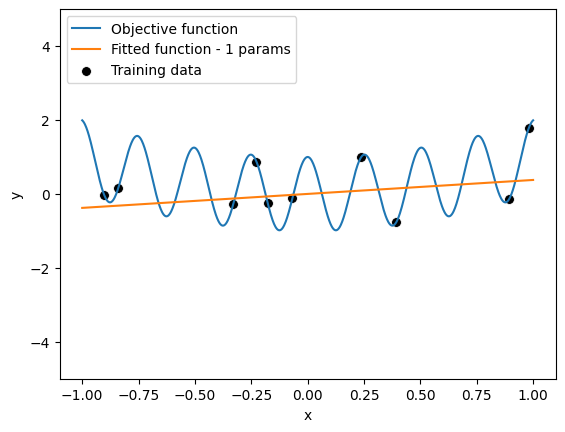

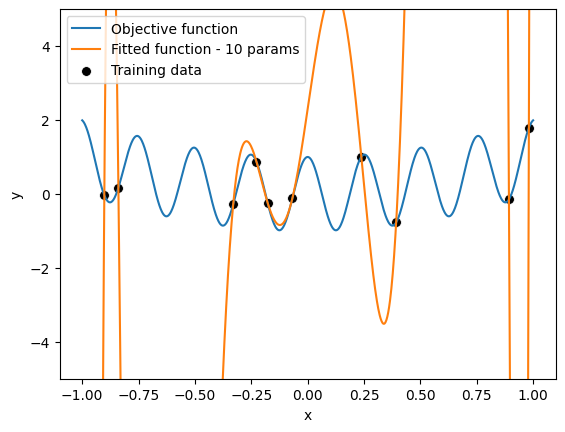

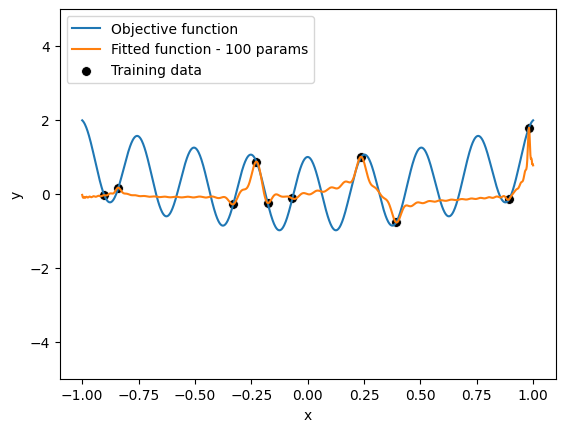

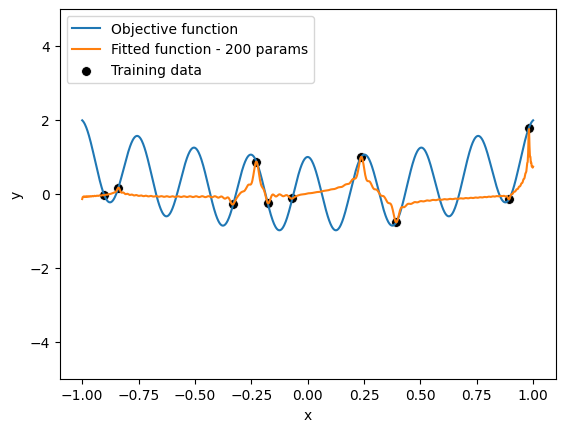

In [ ]:
y_lower, y_upper = -5, 5

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

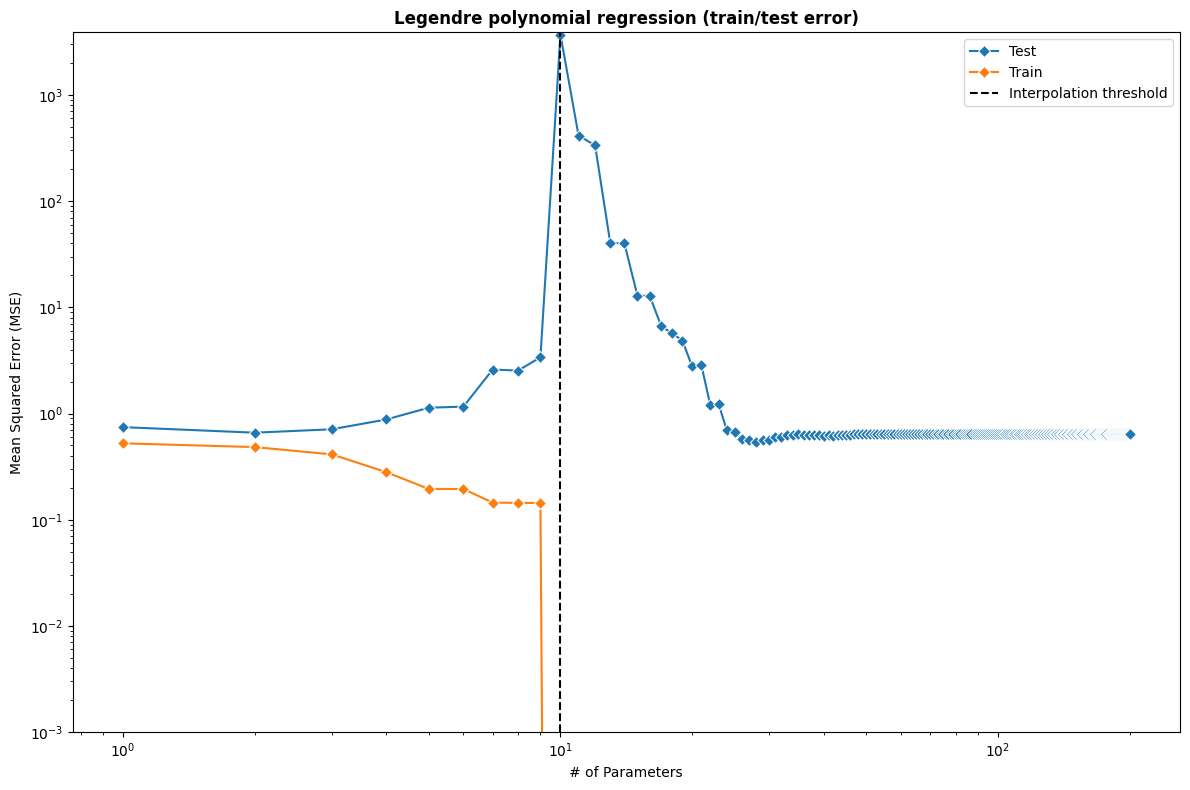

In [ ]:
plot_double_descent(output_df, n_samples)

\

## **1.3 Third experiment $(e^{3x} + cos(25x))$**

In [ ]:
def objective_function(x):
  '''
  Objective function (unknown) we want to approximate using training data. In this
  case we use y(x) = exp(3x) + cos(25x) as objective function

  '''
  return np.float64(np.exp(3*x) + np.cos(25*x))

The new objective function changes the trend function ($2x$) from linear to exponential ($e^{3x}$).

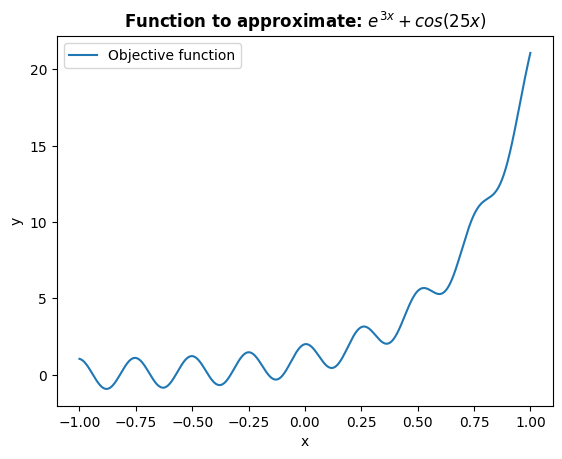

In [ ]:
plot_objective_function(objective_function, "$e^{3x} + cos(25x)$")

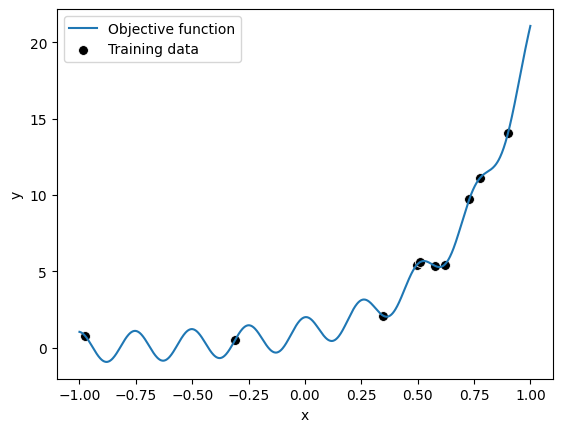

In [ ]:
# Here we generate the training data and we plot them together with the objective function
lower_bound, higher_bound = -1.0, 1.0
X_test = np.linspace(lower_bound, higher_bound, num=1000)
y_test = objective_function(X_test)
n_samples = 10
X_train, y_train = generate_training_data(lower_bound, higher_bound, n_samples, objective_function)
plot_objective_function_and_training_data(X_train, y_train, X_test, y_test)

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Number of params we want to use for the approximation
degrees = list(range(1, 201))

# For each degree in [1, 200] we calculate the fitted function and see how it fits the objective function by using MSE in training and test.
for degree in degrees:
  X_train_poly, y_train_pred, y_test_pred = fit_legendre_polynomial_regression(degree, X_train, y_train, X_test)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "X_train_poly": X_train_poly, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# We convert the output into a pandas dataframe
output_df = pd.DataFrame(output)

# of parameters = 1, train_loss = 16.7362, test_loss = 21.2694
# of parameters = 2, train_loss = 5.4321, test_loss = 15.6398
# of parameters = 3, train_loss = 5.2819, test_loss = 16.3595
# of parameters = 4, train_loss = 5.0382, test_loss = 19.1101
# of parameters = 5, train_loss = 0.6786, test_loss = 78.2505
# of parameters = 6, train_loss = 0.4714, test_loss = 58.3433
# of parameters = 7, train_loss = 0.0798, test_loss = 267.6263
# of parameters = 8, train_loss = 0.0222, test_loss = 10986.1558
# of parameters = 9, train_loss = 0.0001, test_loss = 1315001.7969
# of parameters = 10, train_loss = 0.0000, test_loss = 11672471.7404
# of parameters = 11, train_loss = 0.0000, test_loss = 288766.1471
# of parameters = 12, train_loss = 0.0000, test_loss = 46516.6357
# of parameters = 13, train_loss = 0.0000, test_loss = 9021.3742
# of parameters = 14, train_loss = 0.0000, test_loss = 3944.3192
# of parameters = 15, train_loss = 0.0000, test_loss = 1897.9095
# of parameters = 16, train_loss = 

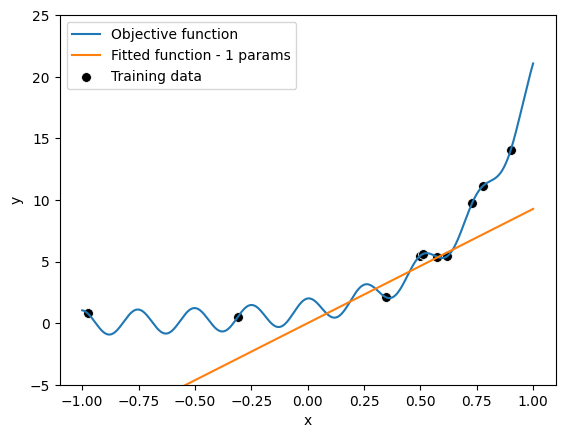

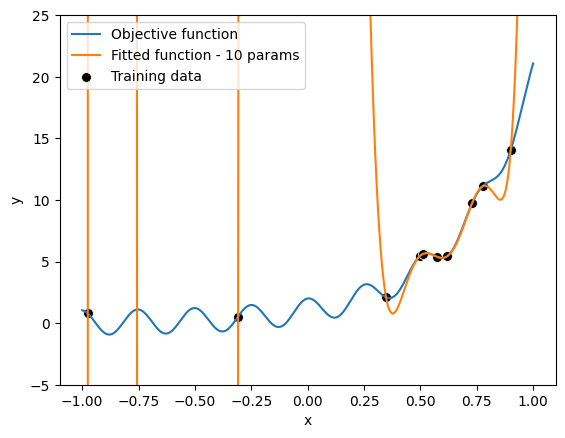

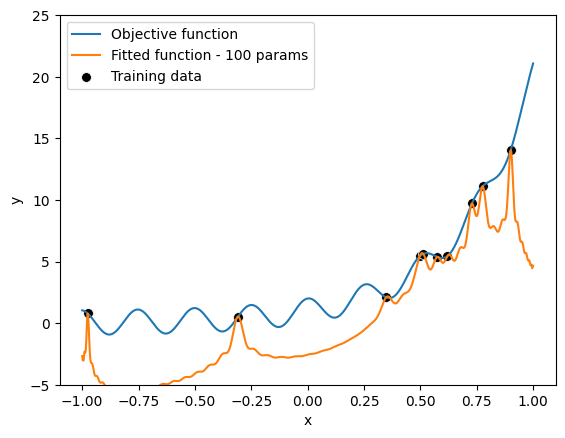

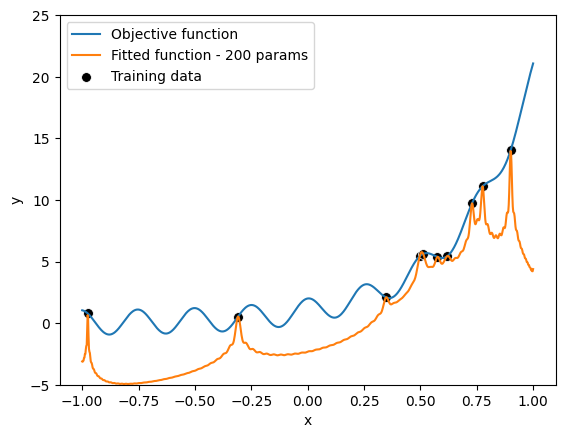

In [ ]:
y_lower, y_upper = -5, 25

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

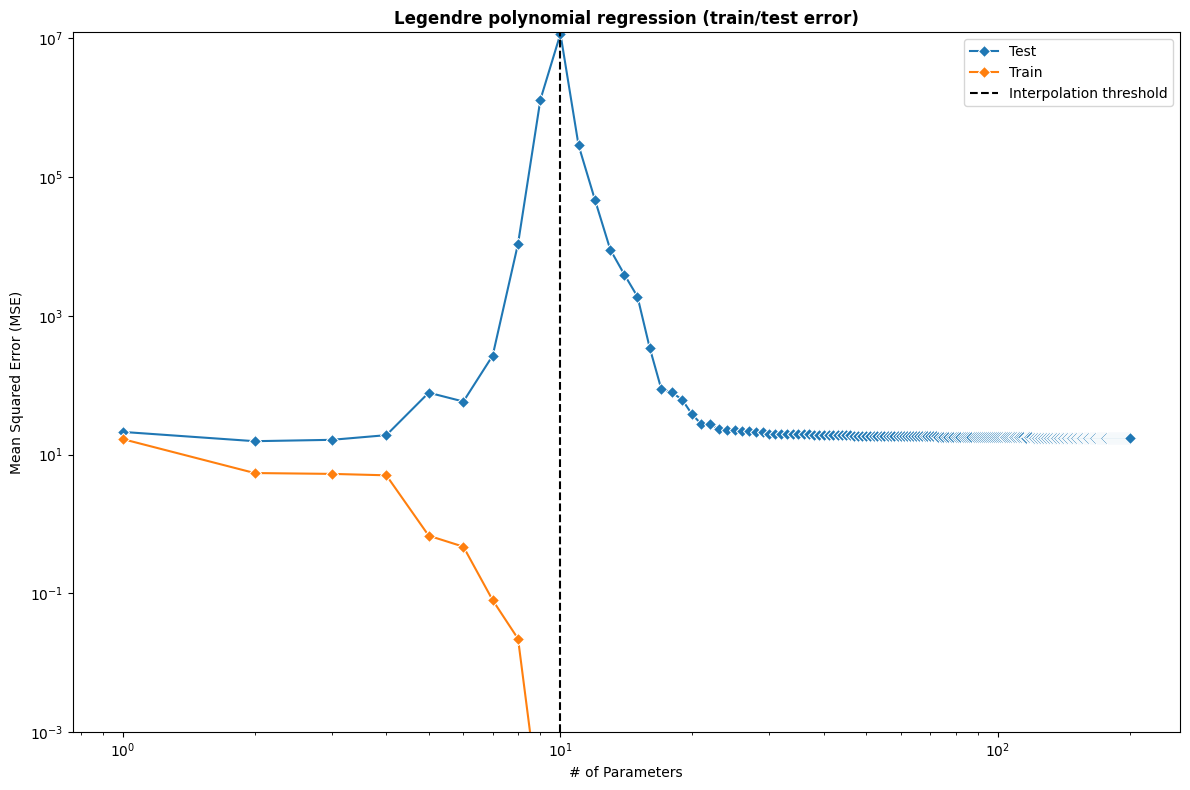

In [ ]:
plot_double_descent(output_df, n_samples)

\

## **1.4 Fourth experiment $(tanh(x))$**

In [ ]:
def objective_function4(x):
  '''
  Objective function (unknown) we want to approximate using training data. In this
  case we use y(x) = tanh(x) as objective function

  '''
  return np.float64(np.tanh(x))

The new objective function changes the trend function ($2x$) from linear to hyperbolic ($tanh(x)$) and the "noise" function ($cos(25x)$) has been removed.

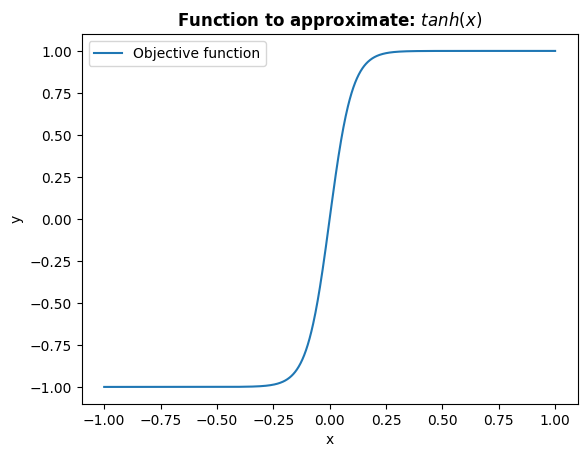

In [ ]:
plot_objective_function(objective_function4, "$tanh(x)$", -10, 10)

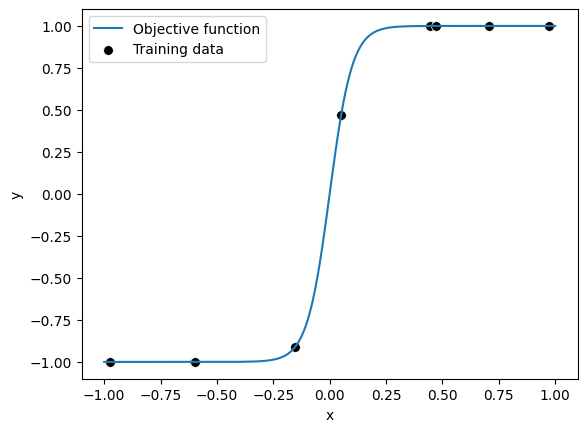

In [ ]:
# Here we generate the training data and we plot them together with the objective function
lower_bound, higher_bound = -10.0, 10.0
X_test = np.linspace(lower_bound, higher_bound, num=1000)
y_test = objective_function4(X_test)
# Normalizar X_test al rango [-1, 1]
X_test = 2 * (X_test - lower_bound) / (higher_bound - lower_bound) - 1
n_samples = 10
X_train, y_train = generate_uniformly_distributed_training_data(lower_bound, higher_bound, n_samples, objective_function4)
plot_objective_function_and_training_data(X_train, y_train, X_test, y_test)

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Number of params we want to use for the approximation
degrees = list(range(1, 201))

# For each degree in [1, 200] we calculate the fitted function and see how it fits the objective function by using MSE in training and test.
for degree in degrees:
  X_train_poly, y_train_pred, y_test_pred = fit_legendre_polynomial_regression(degree, X_train, y_train, X_test)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "X_train_poly": X_train_poly, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# We convert the output into a pandas dataframe
output_df = pd.DataFrame(output)

# of parameters = 1, train_loss = 0.1240, test_loss = 0.1643
# of parameters = 2, train_loss = 0.1240, test_loss = 0.1643
# of parameters = 3, train_loss = 0.0494, test_loss = 0.0729
# of parameters = 4, train_loss = 0.0483, test_loss = 0.0734
# of parameters = 5, train_loss = 0.0233, test_loss = 0.0391
# of parameters = 6, train_loss = 0.0090, test_loss = 0.2125
# of parameters = 7, train_loss = 0.0003, test_loss = 0.0863
# of parameters = 8, train_loss = 0.0001, test_loss = 0.1825
# of parameters = 9, train_loss = 0.0000, test_loss = 0.3810
# of parameters = 10, train_loss = 0.0000, test_loss = 0.2728
# of parameters = 11, train_loss = 0.0000, test_loss = 0.0189
# of parameters = 12, train_loss = 0.0000, test_loss = 0.0193
# of parameters = 13, train_loss = 0.0000, test_loss = 0.0127
# of parameters = 14, train_loss = 0.0000, test_loss = 0.0157
# of parameters = 15, train_loss = 0.0000, test_loss = 0.0249
# of parameters = 16, train_loss = 0.0000, test_loss = 0.0331
# of parameters =

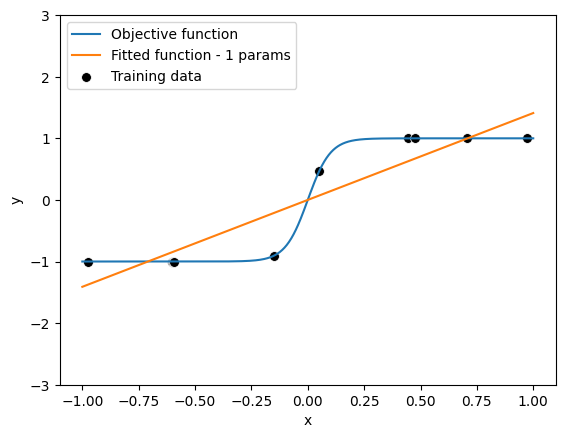

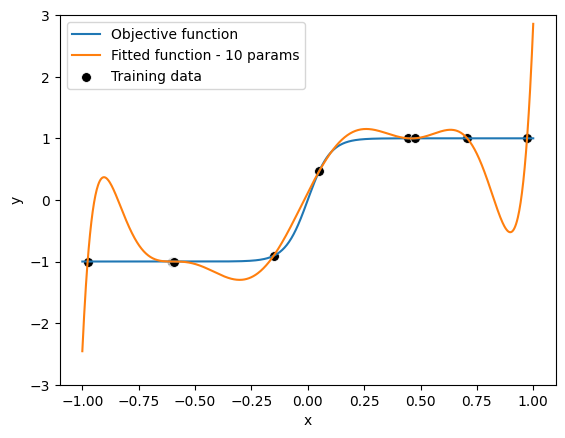

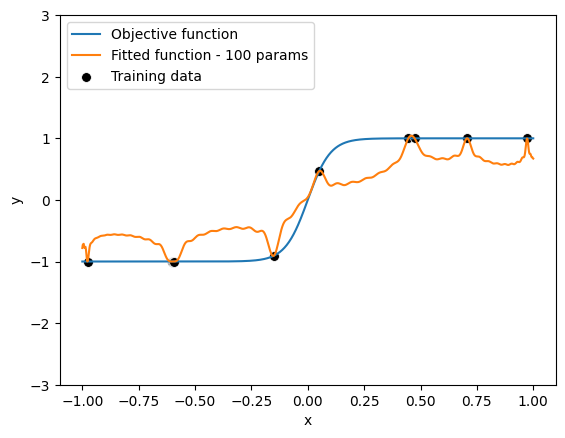

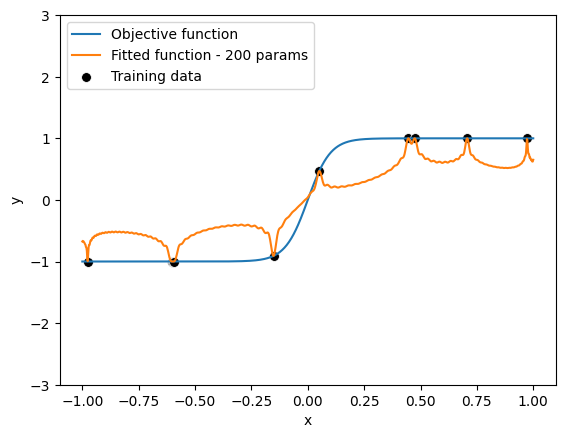

In [ ]:
y_lower, y_upper = -3, 3

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

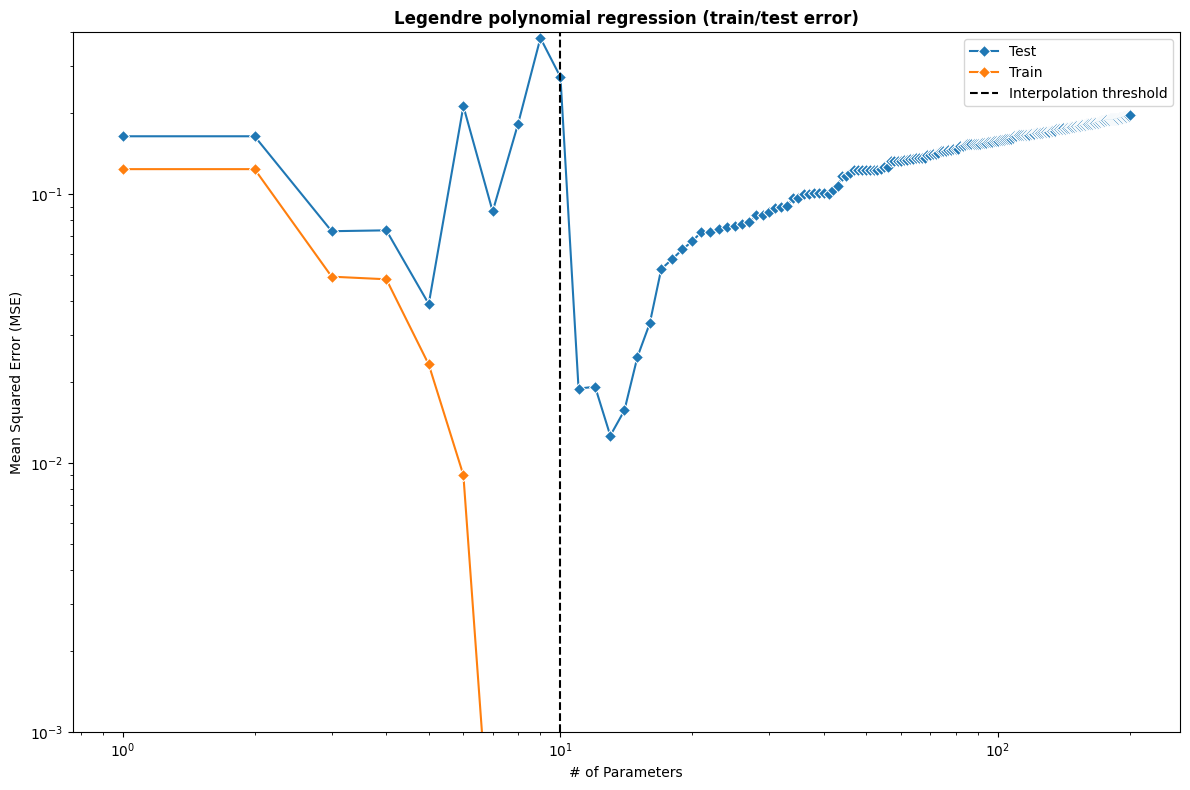

In [ ]:
plot_double_descent(output_df, n_samples)

\

### **$1.4.1 \: tanh(x) + cos(25x)$**

In [ ]:
def objective_function4_1(x):
  '''
  Objective function (unknown) we want to approximate using training data. In this
  case we use y(x) = tanh(x) + cos(25x) as objective function

  '''
  return np.float64(np.tanh(x) + np.cos(25*x))

In this case we add the "noise" function ($cos(25x)$) to the previous trend function.

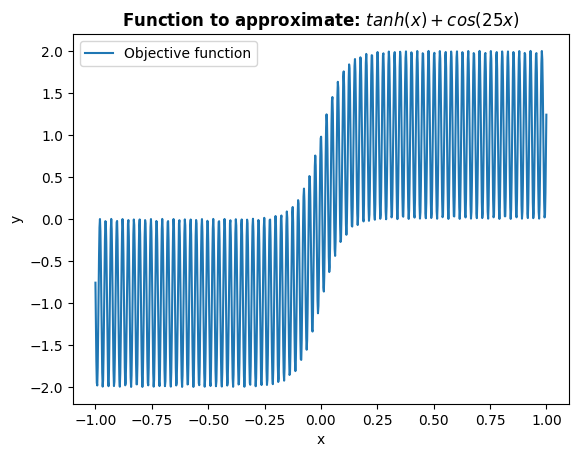

In [ ]:
plot_objective_function(objective_function4_1, "$tanh(x) + cos(25x)$", -10, 10)

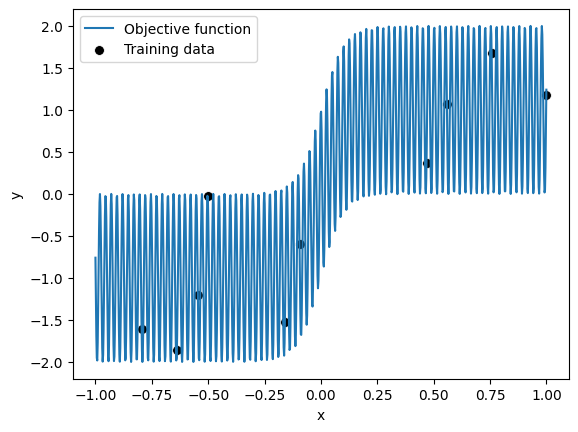

In [ ]:
# Here we generate the training data and we plot them together with the objective function
lower_bound, higher_bound = -10.0, 10.0
X_test = np.linspace(lower_bound, higher_bound, num=1000)
y_test = objective_function4(X_test)
# Normalizar X_test al rango [-1, 1]
X_test = 2 * (X_test - lower_bound) / (higher_bound - lower_bound) - 1
n_samples = 10
X_train, y_train = generate_uniformly_distributed_training_data(lower_bound, higher_bound, n_samples, objective_function4)
plot_objective_function_and_training_data(X_train, y_train, X_test, y_test)

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Number of params we want to use for the approximation
degrees = list(range(1, 201))

# For each degree in [1, 200] we calculate the fitted function and see how it fits the objective function by using MSE in training and test.
for degree in degrees:
  X_train_poly, y_train_pred, y_test_pred = fit_legendre_polynomial_regression(degree, X_train, y_train, X_test)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "X_train_poly": X_train_poly, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# We convert the output into a pandas dataframe
output_df = pd.DataFrame(output)

# of parameters = 1, train_loss = 0.3791, test_loss = 0.6911
# of parameters = 2, train_loss = 0.3784, test_loss = 0.6892
# of parameters = 3, train_loss = 0.3363, test_loss = 0.6143
# of parameters = 4, train_loss = 0.3134, test_loss = 0.6969
# of parameters = 5, train_loss = 0.2591, test_loss = 1.0451
# of parameters = 6, train_loss = 0.1285, test_loss = 5.4548
# of parameters = 7, train_loss = 0.1239, test_loss = 4.6132
# of parameters = 8, train_loss = 0.1238, test_loss = 4.3285
# of parameters = 9, train_loss = 0.0409, test_loss = 5.3119
# of parameters = 10, train_loss = 0.0000, test_loss = 1029.4332
# of parameters = 11, train_loss = 0.0000, test_loss = 40.4833
# of parameters = 12, train_loss = 0.0000, test_loss = 34.6579
# of parameters = 13, train_loss = 0.0000, test_loss = 8.2703
# of parameters = 14, train_loss = 0.0000, test_loss = 2.3463
# of parameters = 15, train_loss = 0.0000, test_loss = 2.3537
# of parameters = 16, train_loss = 0.0000, test_loss = 1.7170
# of paramet

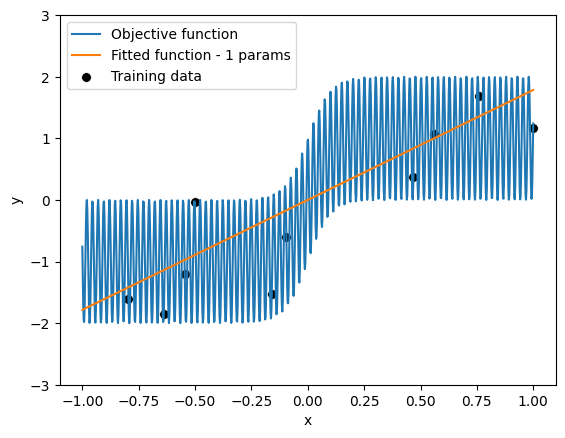

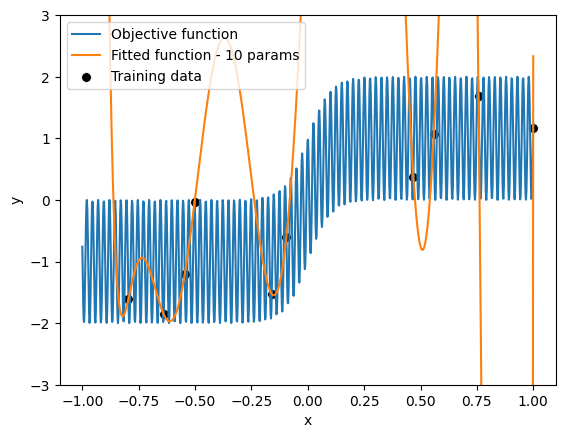

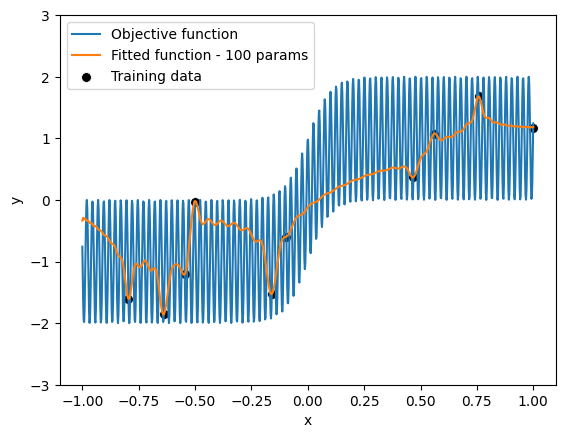

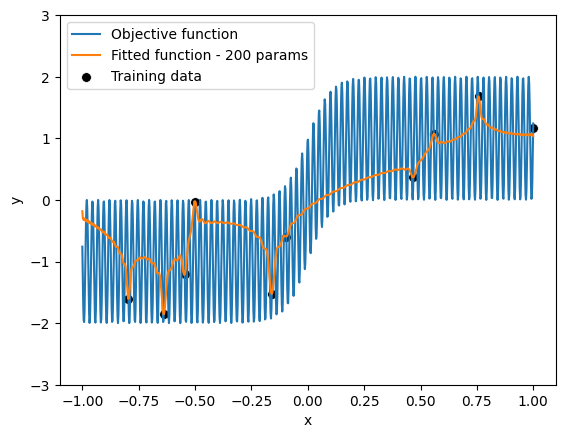

In [ ]:
y_lower, y_upper = -3, 3

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

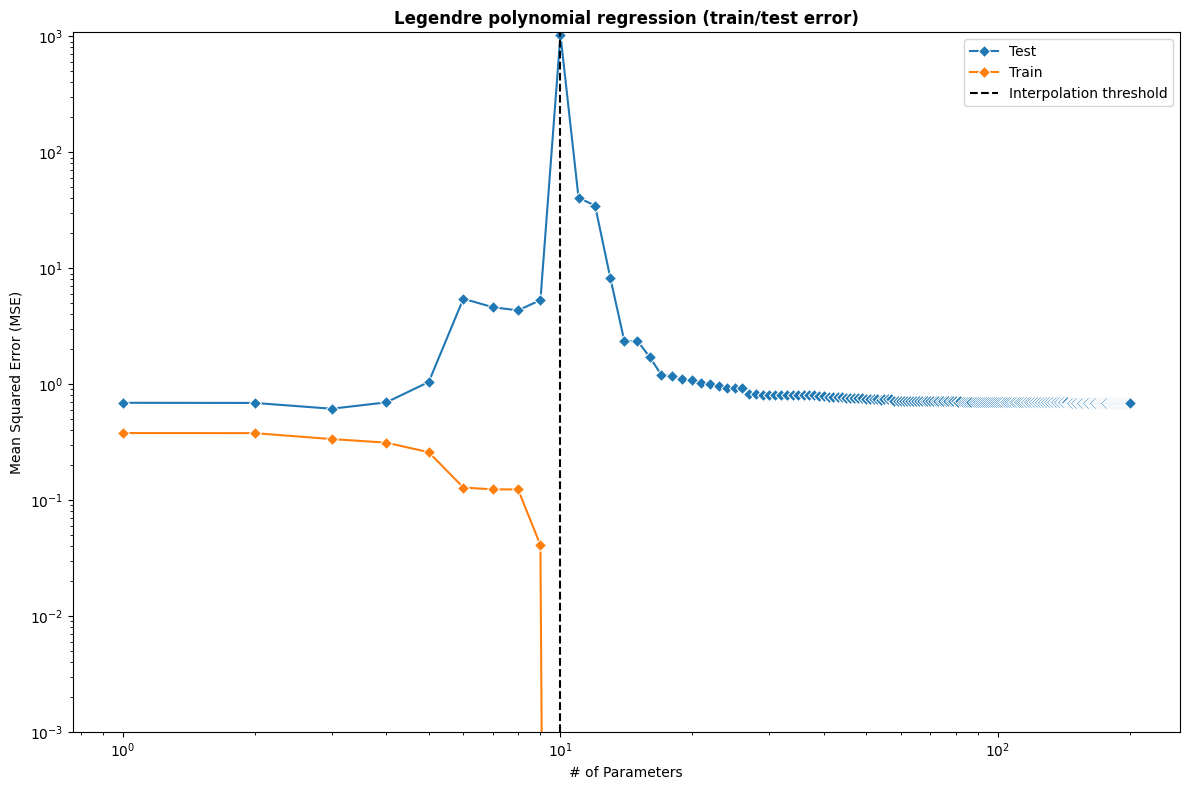

In [ ]:
plot_double_descent(output_df, n_samples)

\

# **2. Polynomial Features using OLS**

We will now perform the same approximation of the objective functions from standard polynomial regression, instead of using Legendre polynomials.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_polynomial_regression(degree, X_train, y_train, X_test):
  '''
  Function to perform polynomial regression using standard polynomial features.

  Example of use:
  X_train_poly, y_train_pred, y_test_pred = fit_polynomial_regression(3, X_train, y_train, X_test)

  '''
  # Reshape input data to ensure 2D format
  X_train = X_train.reshape(-1, 1)
  X_test = X_test.reshape(-1, 1)

  # Create polynomial features using PolynomialFeatures()
  poly = PolynomialFeatures(degree=degree)
  X_train_poly = poly.fit_transform(X_train)
  X_test_poly = poly.transform(X_test)

  # Fit the linear regression model using LinearRegression()
  model = LinearRegression()
  model.fit(X_train_poly, y_train)

  # Predict values for training and test sets
  y_train_pred = model.predict(X_train_poly)
  y_test_pred = model.predict(X_test_poly)

  return X_train_poly, y_train_pred, y_test_pred

For this purpose, we use the functions (**PolynomialFeatures()**) and (**LinearRegression()**) of sklearn. The first one will generate the polynomial structure to be approximated and the second one will offer the approximation using the OLS method.

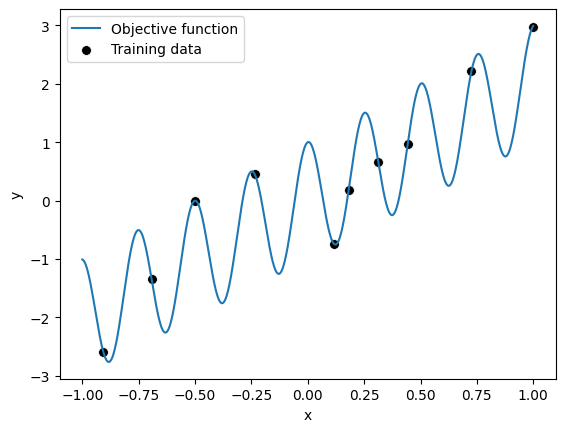

In [ ]:
# Here we generate the training data and we plot them together with the objective function
lower_bound, higher_bound = -1.0, 1.0
X_test = np.linspace(lower_bound, higher_bound, num=1000)
y_test = objective_function1(X_test)
n_samples = 10
X_train, y_train = generate_uniformly_distributed_training_data(lower_bound, higher_bound, n_samples, objective_function1)
plot_objective_function_and_training_data(X_train, y_train, X_test, y_test)

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Number of params we want to use for the approximation (we use [1, 200] params following "arXiv:2303.14151")
degrees = list(range(200000, 200001))

# For each degree in [1, 500] we calculate the fitted function and see how it fits the objective function by using MSE in training and test.
for degree in degrees:
  X_train_poly, y_train_pred, y_test_pred = fit_polynomial_regression(degree, X_train, y_train, X_test)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "X_train_poly": X_train_poly, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# We convert the output into a pandas dataframe
output_df = pd.DataFrame(output)

# of parameters = 200000, train_error = 0.0000, test_error = 53859.8441


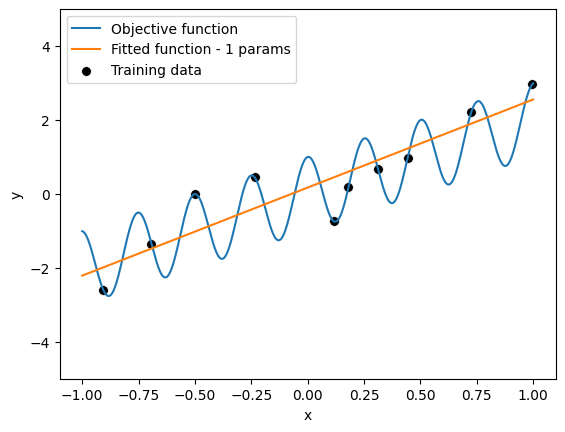

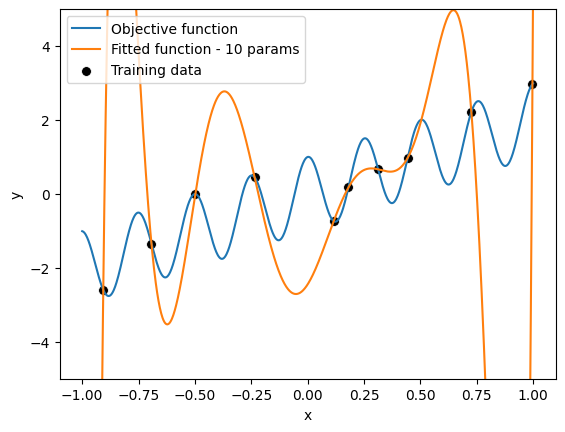

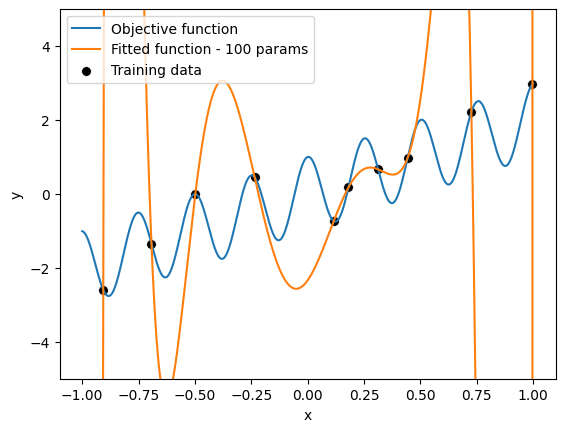

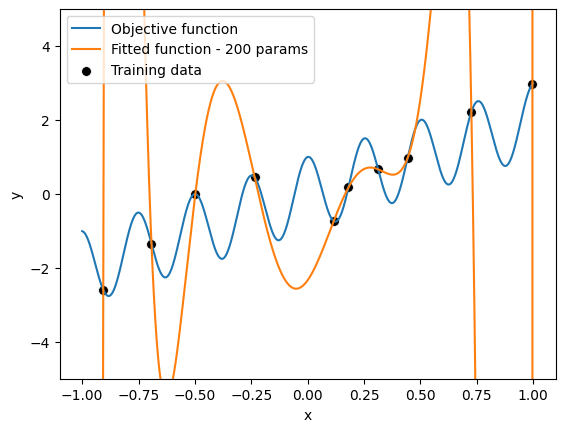

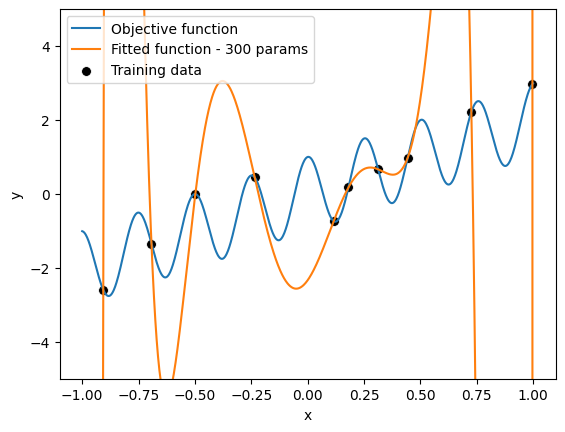

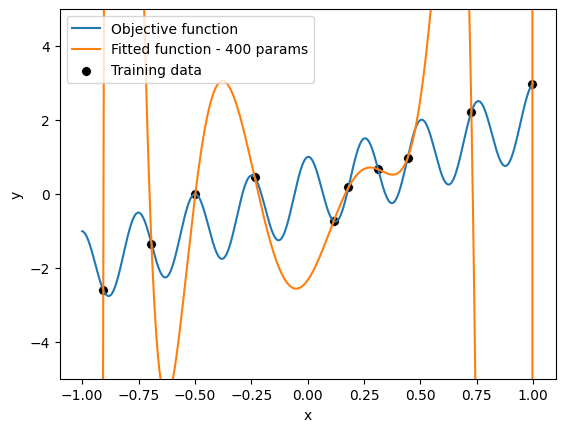

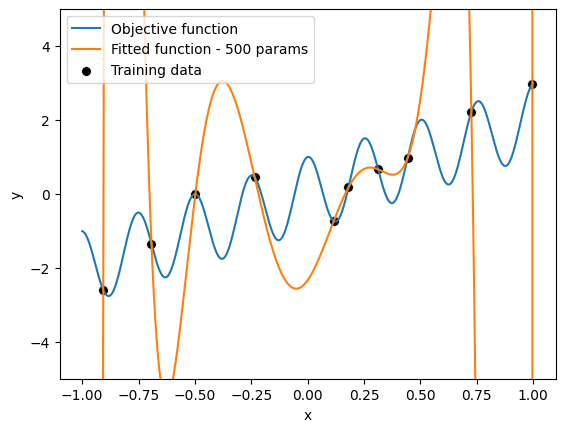

In [ ]:
y_lower, y_upper = -5, 5

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 300
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 400
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 500
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

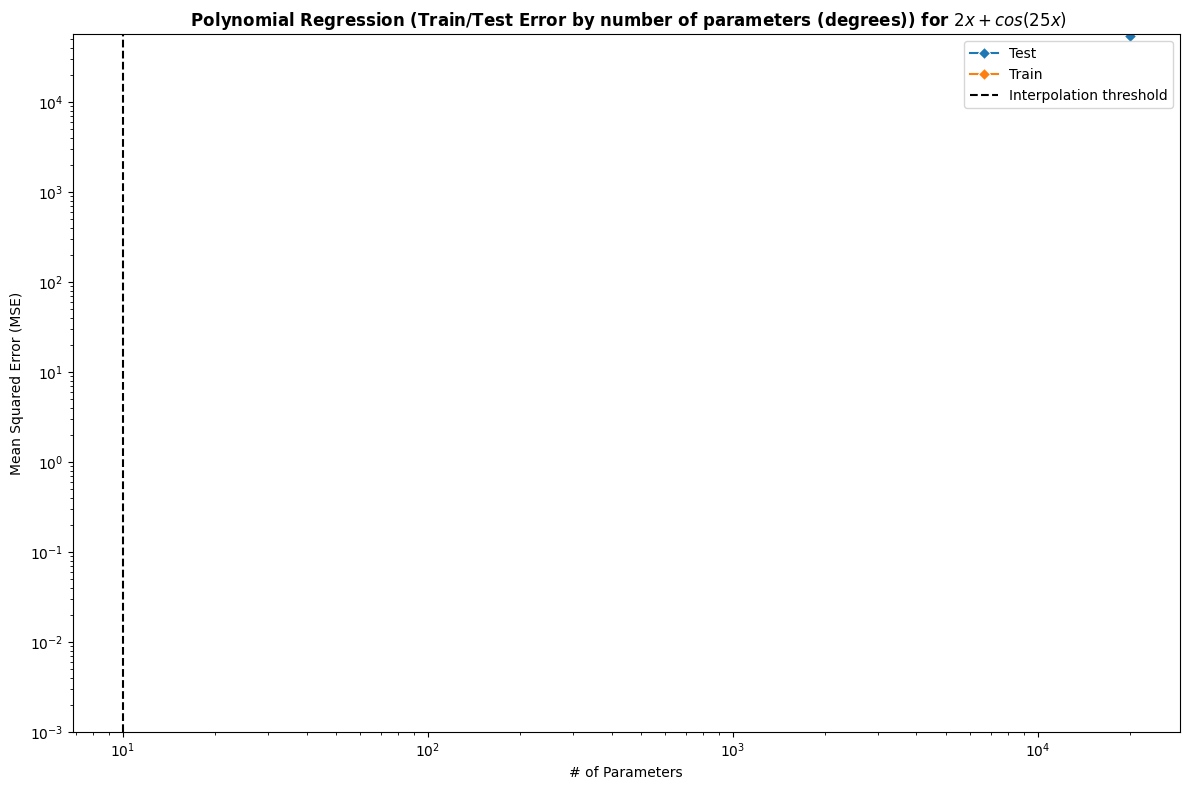

In [ ]:
plot_double_descent(output_df, n_samples, "$2x + cos(25x)$", False)

\

# **3. Polynomial Features using GD**

In this case we will perform the standard polynomial approximation using the gradient descent method instead of the OLS method.

In [ ]:
def poly_features(X, degree):
  '''
  Function to generate polynomial features using up to a given degree.

  '''
  X = X.reshape(-1, 1)
  X_poly = np.ones((X.shape[0], 1))

  # Iterate through degrees from 1 to specified degree and append polynomial terms of X to the matrix
  # When X is a 1D input this is the same as using PolynomialFeatures()
  for d in range(1, degree + 1):
      X_poly = np.hstack((X_poly, X**d))

  return X_poly

def forward_pass(X, w, b):
  '''
  Function to compute the forward pass in linear regression using the features (X),
  the weights (w) and the bias (b).

  '''
  return np.dot(X, w) + b

def loss_MSE(y, y_pred):
  '''
  Function to compute Mean Squared Error (MSE) loss.

  '''
  y = y.reshape(-1, 1)
  loss = np.mean((y_pred-y)**2)

  return loss

def derivatives(X, y, y_pred):
  '''
  Function to compute the gradient of loss with respect to weights and bias.

  '''
  y = y.reshape(-1, 1)

  # Compute gradient for bias and weigths following https://www.kaggle.com/code/grayphantom/polynomial-regression-using-gradient-descent
  db = 2 * np.mean(y_pred - y)
  dw = 2 * np.dot(X.T, (y_pred - y)) / X.shape[0]

  return db, dw

def predict(X, weights, bias, degree):
  '''
  Function to make predictions using a trained polynomial regression model.

  '''
  X = poly_features(X, degree)
  # Compute predictions using weights and bias
  return np.dot(X, weights) + bias

In [ ]:
def train(X_train, y_train, X_test, y_test, degree, learning_rate, epochs):
  '''
  Function to train a polynomial regression model of a certain degree (degree) using
  gradient descent with a given learning rate (learning_rate) and number of epochs (epochs).

  '''
  # Polynomial features for train and test data points
  X_new_train = poly_features(X_train, degree)
  X_new_test = poly_features(X_test, degree)

  # Initial weights and bias set to 0
  n = X_new_train.shape[1]
  weights = np.zeros((n,1))
  bias = 0

  # Training loop
  for epoch in range(epochs+1):
    # Forward pass
    y_pred = forward_pass(X_new_train, weights, bias)

    # We calculate the derivatives with respect to w and b (gradient)
    db, dw = derivatives(X_new_train, y_train, y_pred)

    # We need to modify all weights including bias (update weights)
    weights -= learning_rate * dw
    bias -= learning_rate * db

  return bias, weights

In [ ]:
output = []

# Rango de grados [1, 200]
degrees = list(range(1, 201))

for degree in degrees:
  # Entrenar el modelo con las características generadas
  bias, weights = train(X_train, y_train, X_test, y_test, degree, learning_rate = 0.01, epochs = 5000)

  y_train_pred = predict(X_train, weights, bias, degree)
  y_test_pred = predict(X_test, weights, bias, degree)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# Convertir la salida a un dataframe de pandas para análisis posterior
output_df = pd.DataFrame(output)

# of parameters = 1, train_error = 0.3369, test_error = 0.4996
# of parameters = 2, train_error = 0.3348, test_error = 0.5018
# of parameters = 3, train_error = 0.2872, test_error = 0.5452
# of parameters = 4, train_error = 0.2695, test_error = 0.5454
# of parameters = 5, train_error = 0.2655, test_error = 0.5543
# of parameters = 6, train_error = 0.2412, test_error = 0.5686
# of parameters = 7, train_error = 0.2370, test_error = 0.5770
# of parameters = 8, train_error = 0.2147, test_error = 0.5981
# of parameters = 9, train_error = 0.2109, test_error = 0.6069
# of parameters = 10, train_error = 0.1947, test_error = 0.6246
# of parameters = 11, train_error = 0.1924, test_error = 0.6307
# of parameters = 12, train_error = 0.1825, test_error = 0.6396
# of parameters = 13, train_error = 0.1816, test_error = 0.6420
# of parameters = 14, train_error = 0.1763, test_error = 0.6425
# of parameters = 15, train_error = 0.1762, test_error = 0.6419
# of parameters = 16, train_error = 0.1735, test_

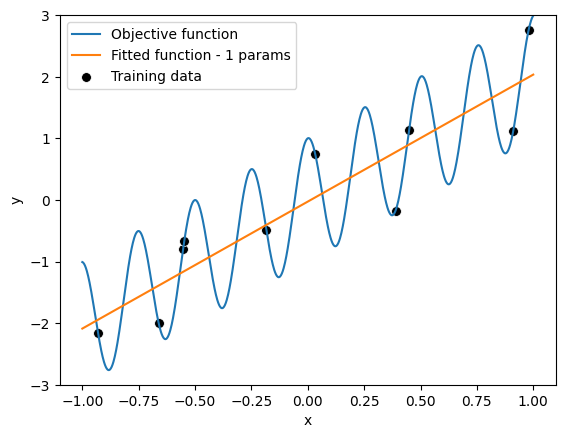

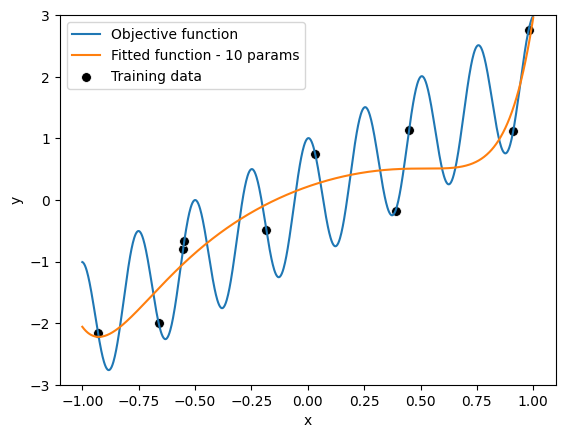

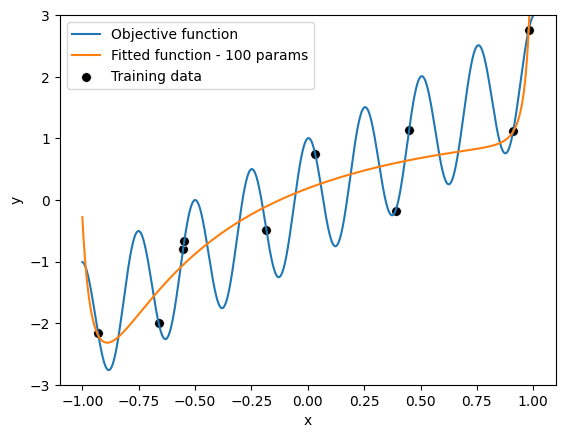

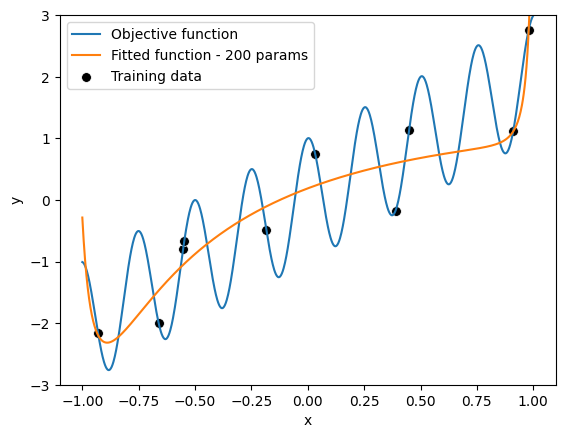

In [ ]:
y_lower, y_upper = -3, 3

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'].flatten(), output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'].flatten(), output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'].flatten(), output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'].flatten(), output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

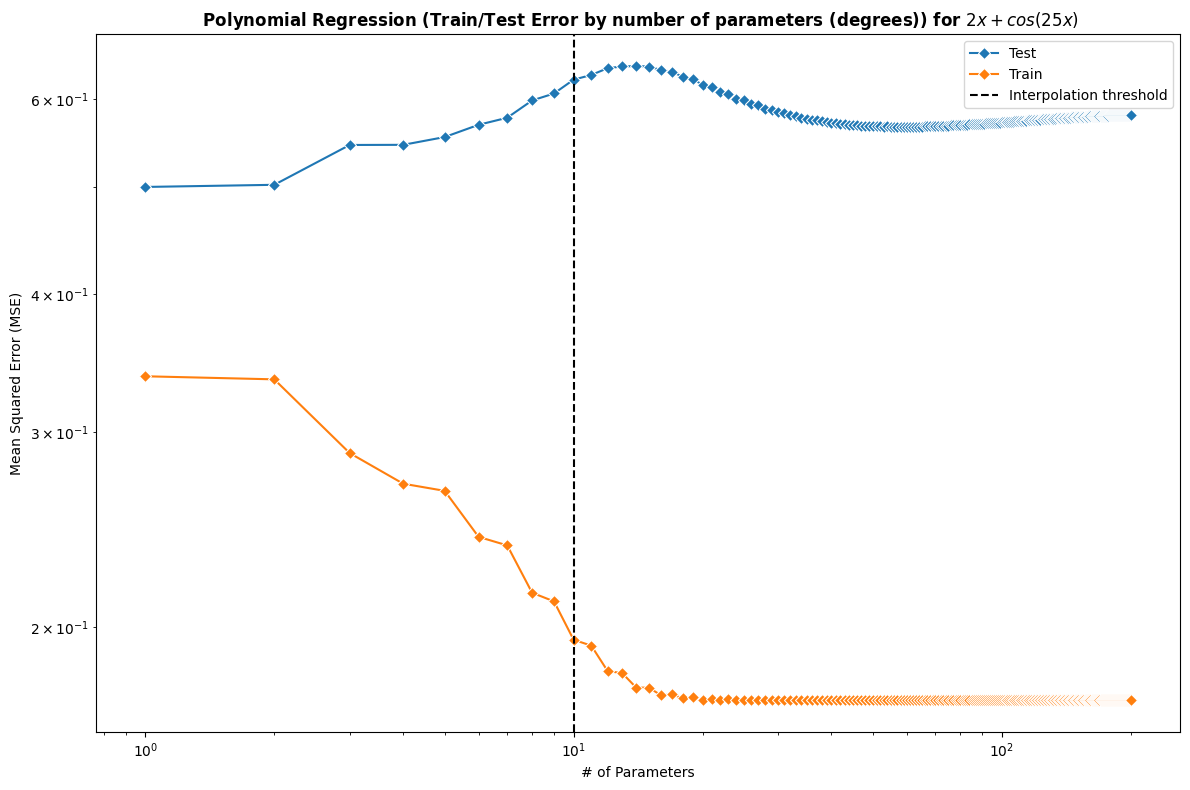

In [ ]:
plot_double_descent(output_df, n_samples, "$2x + cos(25x)$", False, 0)

 \

# **3. Polynomial Features using SGDRegressor**

Finally, we use the **"SGDRegressor"** model to perform the approximation of the objective function.

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

def train_with_sgd(X_train, y_train, X_test, y_test, degree, learning_rate, epochs):
    '''
    Function to train a polynomial regression model of a certain degree (degree) using
    stochastic gradient descent (SGD) with a given learning rate (learning_rate) and
    number of epochs (epochs).

    '''

    # Reshape training and testing features to be column vectors
    X_train = X_train.reshape(-1, 1)
    X_test = X_test.reshape(-1, 1)

    # Convert target values to 1D arrays
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    model = make_pipeline(
        # Generate polynomial features up to the given degree
        PolynomialFeatures(degree),
        # Normalize features to improve convergence speed
        StandardScaler(),
        SGDRegressor(
            loss = 'squared_error',  # Use squared error loss function (same as MSE)
            penalty = None,  # No regularization term
            alpha = 0.0,  # No weight decay applied
            l1_ratio = 0.0,  # Not using L1 regularization
            fit_intercept = True,  # Include the bias term in the model
            max_iter = epochs,  # Number of passes over the training data
            tol = None,  # Disable early stopping
            shuffle = False,  # Do not shuffle data between iterations
            random_state = 42,  # Set random seed for reproducibility
            learning_rate = 'constant',  # Keep a fixed learning rate
            eta0 = learning_rate  # Initial learning rate used in gradient updates
        )
    )

    # Train and fit the model using stochastic gradient descent
    model.fit(X_train, y_train)

    # Generate predictions for both training and testing datasets
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    return model, y_pred_train, y_pred_test

In [ ]:
output = []

from sklearn.metrics import mean_squared_error

# Rango de grados [1, 200]
degrees = list(range(1, 201))

# Suponiendo que X_train, y_train, X_test, y_test ya están definidos
for degree in degrees:
  # Entrenar el modelo con las características generadas
  model, y_train_pred, y_test_pred = train_with_sgd(X_train, y_train, X_test, y_test, degree, learning_rate = 0.0001, epochs = 1000)

  # We calculate the MSE for the training and test data
  train_error = mean_squared_error(y_train, y_train_pred)
  test_error = mean_squared_error(y_test, y_test_pred)

  # We print the degree and both the MSE in training and the MSE in test for that approximation
  print(f"# of parameters = {degree}, train_error = {train_error:.4f}, test_error = {test_error:.4f}")

  # We save all the results so we can use them lately
  output.append({"# of parameters": degree, "train_error": train_error, "test_error": test_error, "y_test_pred": y_test_pred})

# Convertir la salida a un dataframe de pandas para análisis posterior
output_df = pd.DataFrame(output)

# of parameters = 1, train_error = 0.5723, test_error = 0.6602
# of parameters = 2, train_error = 0.5773, test_error = 0.6717
# of parameters = 3, train_error = 0.3426, test_error = 0.5799
# of parameters = 4, train_error = 0.3437, test_error = 0.5855
# of parameters = 5, train_error = 0.3268, test_error = 0.6340
# of parameters = 6, train_error = 0.3208, test_error = 0.6358
# of parameters = 7, train_error = 0.3326, test_error = 0.6939
# of parameters = 8, train_error = 0.3243, test_error = 0.6944
# of parameters = 9, train_error = 0.3360, test_error = 0.7447
# of parameters = 10, train_error = 0.3277, test_error = 0.7443
# of parameters = 11, train_error = 0.3361, test_error = 0.7859
# of parameters = 12, train_error = 0.3289, test_error = 0.7842
# of parameters = 13, train_error = 0.3348, test_error = 0.8184
# of parameters = 14, train_error = 0.3291, test_error = 0.8154
# of parameters = 15, train_error = 0.3335, test_error = 0.8436
# of parameters = 16, train_error = 0.3292, test_

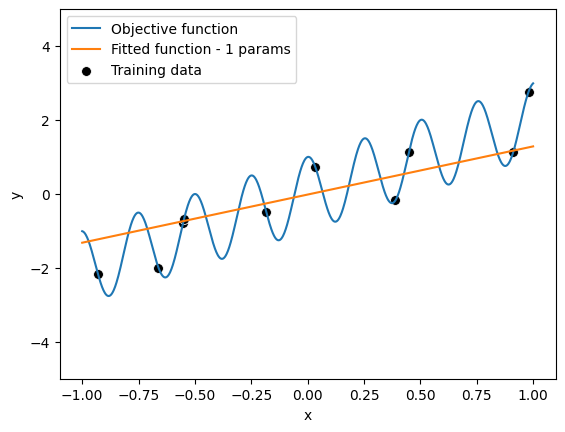

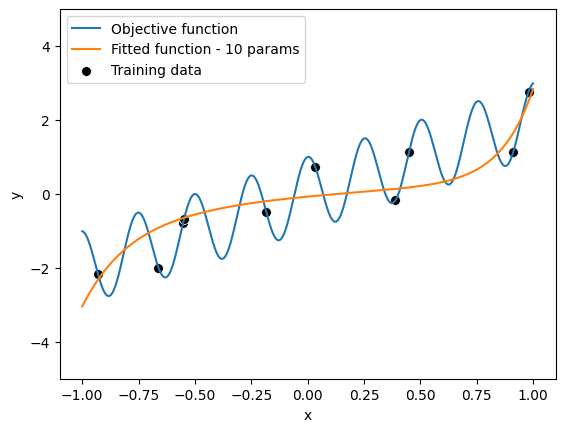

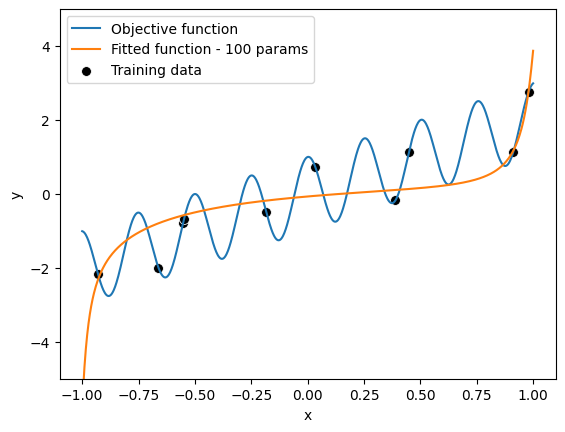

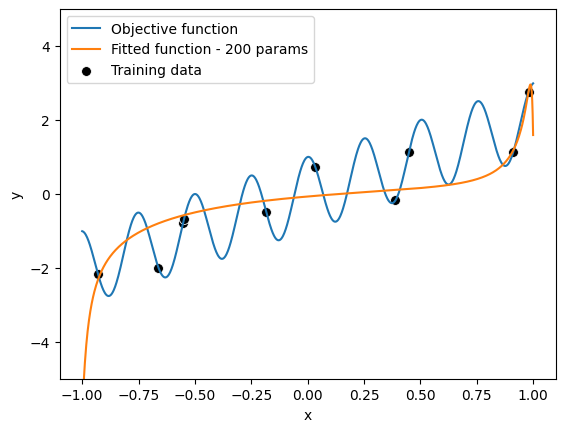

In [ ]:
y_lower, y_upper = -5, 5

# We plot the objective function, fitted function and training data
degree = 1
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 10
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 100
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)
degree = 200
plot_fitting_approximation(X_train, y_train, X_test, y_test, output_df.loc[degree-1, 'y_test_pred'], output_df.loc[degree-1, '# of parameters'], y_lower, y_upper)

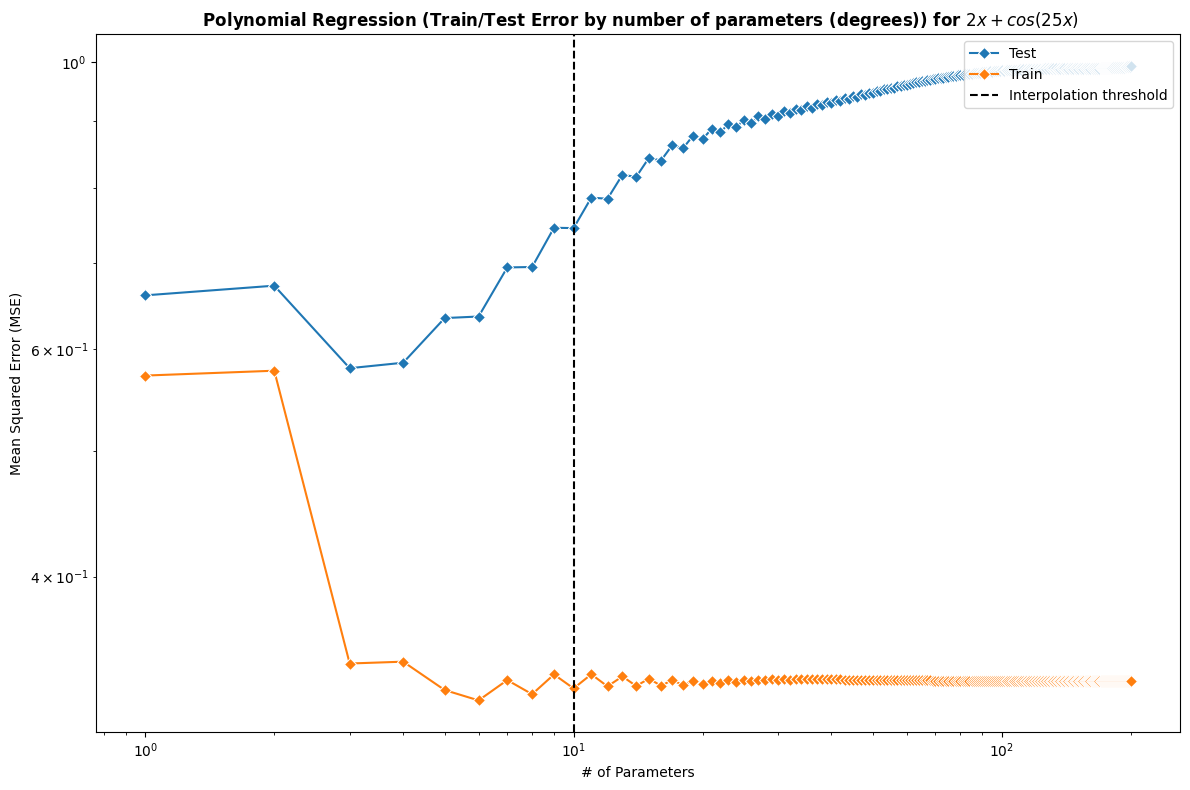

In [ ]:
plot_double_descent(output_df, n_samples, "$2x + cos(25x)$", False, 0)